# Cali Wildfire. EDA.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import optuna

# Initial EDA

In [29]:
cali = pd.read_csv('/Users/isaacfernandez/CaliWildfire/archive (3)/data.csv')

/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/2680289039.py:1: DtypeWarning: Columns (13,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  cali = pd.read_csv('/Users/isaacfernandez/CaliWildfire/archive (3)/data.csv')


In [28]:
cali.columns

Index(['_id', 'OBJECTID', '* Damage', '* Street Number', '* Street Name',
       '* Street Type (e.g. road, drive, lane, etc.)',
       'Street Suffix (e.g. apt. 23, blding C)', '* City', 'State', 'Zip Code',
       '* CAL FIRE Unit', 'County', 'Community', 'Battalion',
       '* Incident Name', 'Incident Number (e.g. CAAEU 123456)',
       'Incident Start Date', 'Hazard Type',
       'If Affected 1-9% - Where did fire start?',
       'If Affected 1-9% - What started fire?',
       'Structure Defense Actions Taken', '* Structure Type',
       'Structure Category', '# Units in Structure (if multi unit)',
       '# of Damaged Outbuildings < 120 SQFT',
       '# of Non Damaged Outbuildings < 120 SQFT', '* Roof Construction',
       '* Eaves', '* Vent Screen', '* Exterior Siding', '* Window Pane',
       '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Distance - Propane Tank to Structure',
    

In [5]:
# Columns with more than 50% missing values
missing_values = cali.isnull().sum()
missing_values[missing_values > len(cali) * 0.5]

Street Suffix (e.g. apt. 23, blding C)                          56082
Zip Code                                                        52801
Battalion                                                       93832
If Affected 1-9% - Where did fire start?                        89490
If Affected 1-9% - What started fire?                           91214
Structure Defense Actions Taken                                 75760
# Units in Structure (if multi unit)                            69046
# of Damaged Outbuildings < 120 SQFT                            69145
# of Non Damaged Outbuildings < 120 SQFT                        69157
Distance - Propane Tank to Structure                            77173
Distance - Residence to Utility/Misc Structure &gt; 120 SQFT    85874
Fire Name (Secondary)                                           79059
dtype: int64

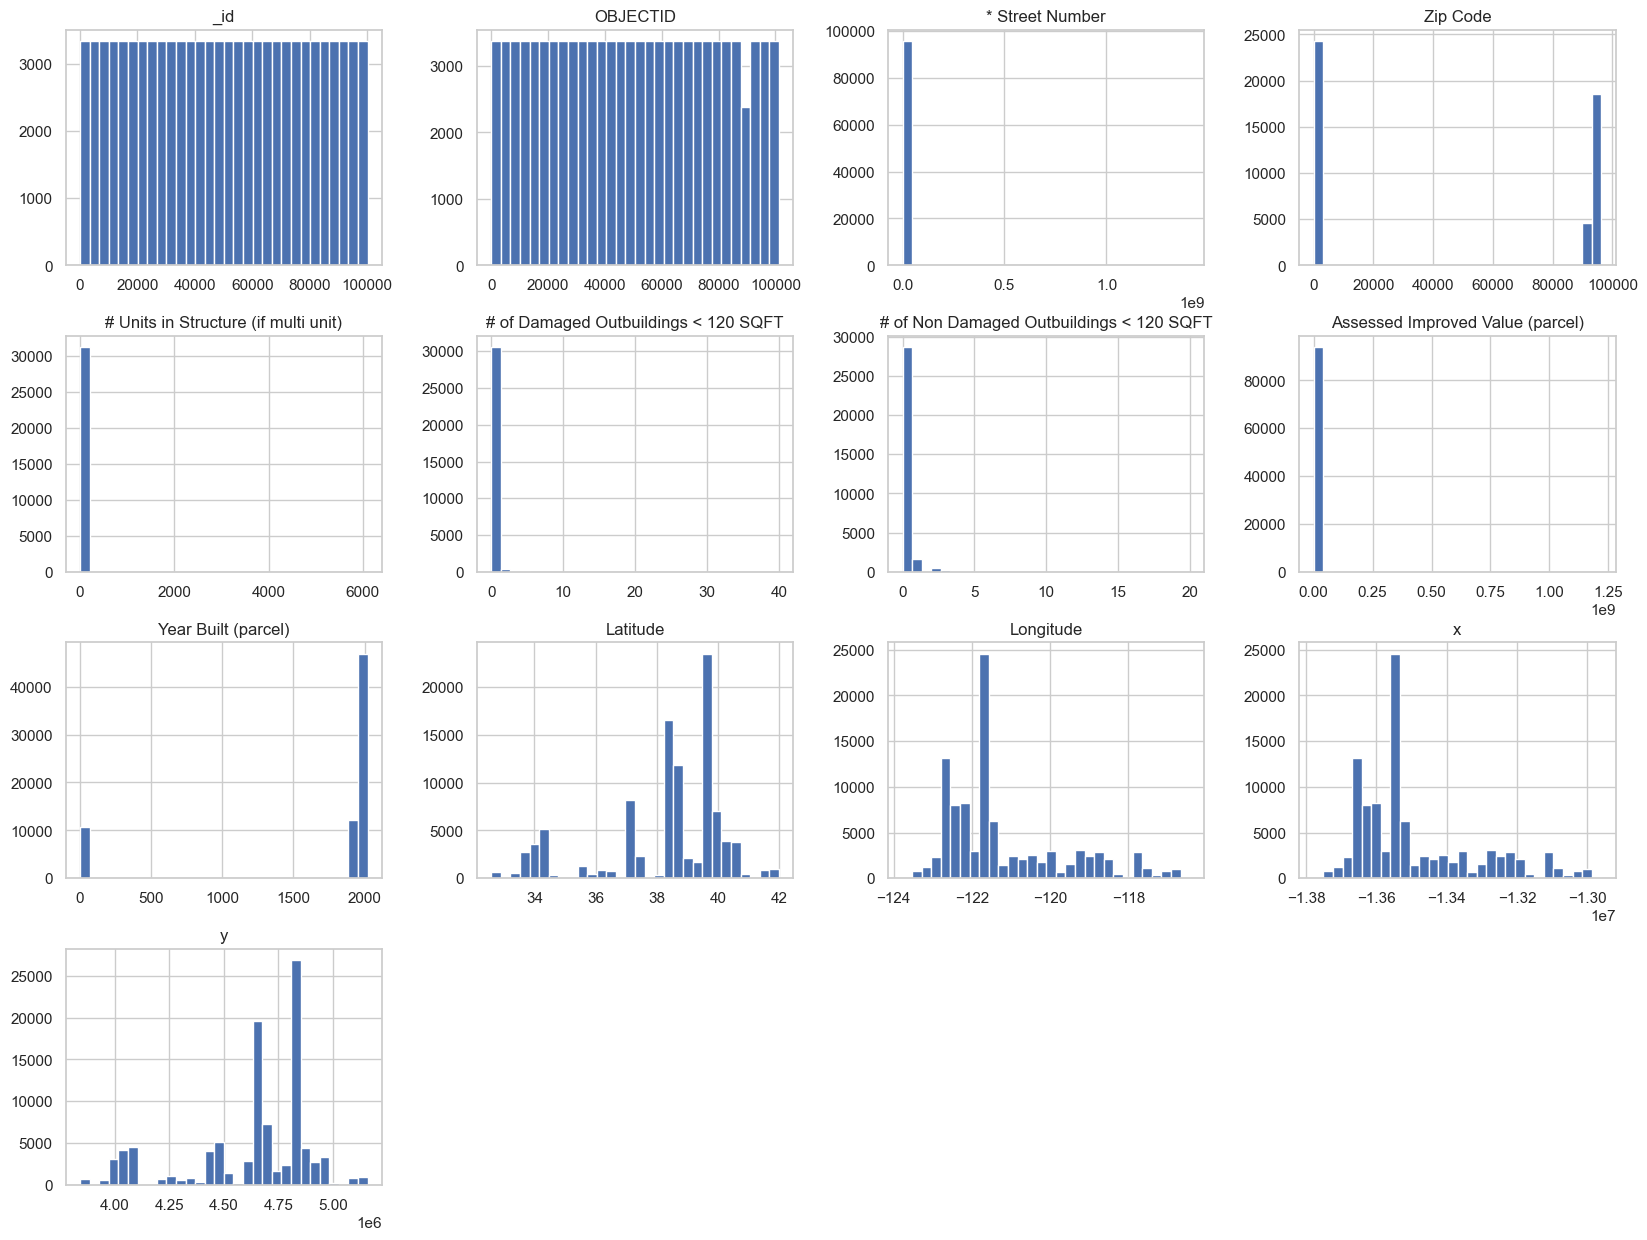

In [10]:

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot histograms for numerical columns
cali.hist(bins=30, figsize=(20, 15))
plt.show()

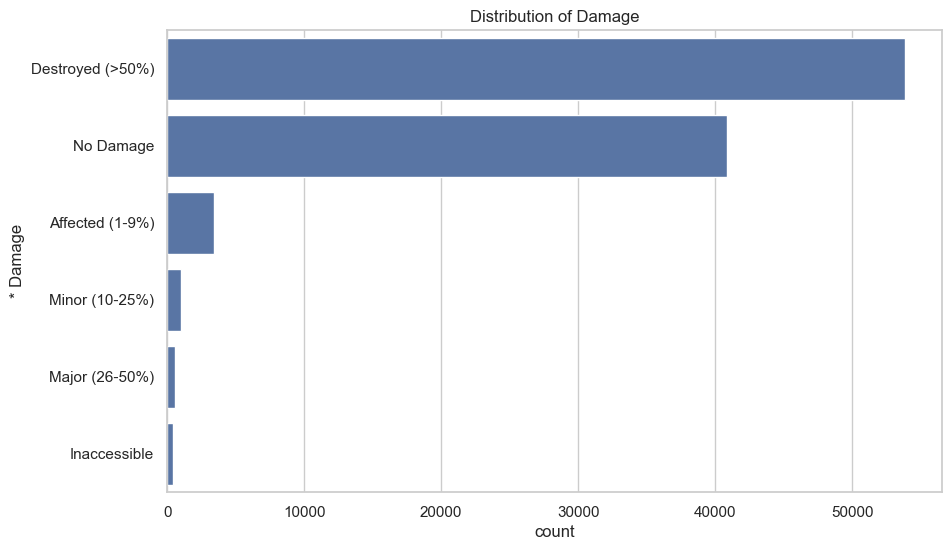

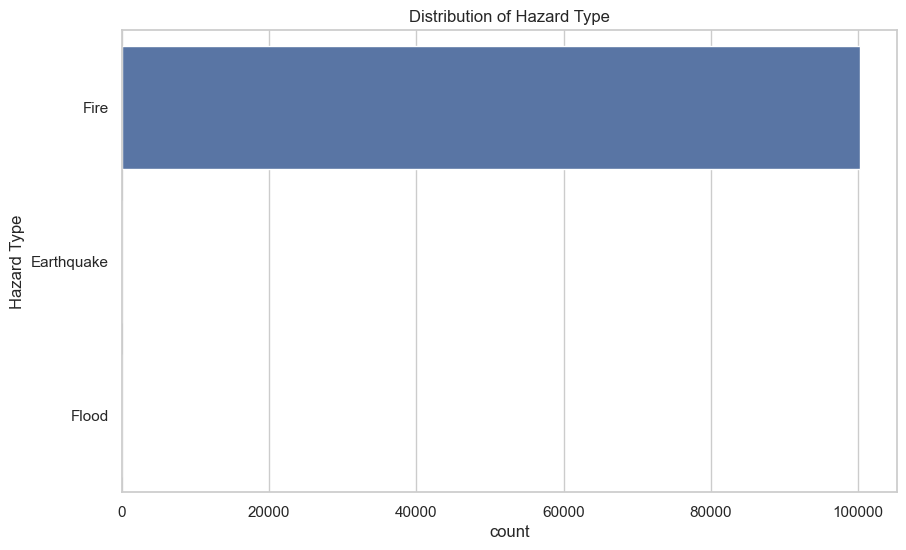

In [15]:
# Plot the distribution of the 'Damage' column
plt.figure(figsize=(10, 6))
sns.countplot(y='* Damage', data=cali, order=cali['* Damage'].value_counts().index)
plt.title('Distribution of Damage')
plt.show()

# Plot the distribution of the 'Hazard Type' column
plt.figure(figsize=(10, 6))
sns.countplot(y='Hazard Type', data=cali, order=cali['Hazard Type'].value_counts().index)
plt.title('Distribution of Hazard Type')
plt.show()

In [16]:
cali.head(2)

,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,...,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,1,No Damage,8376.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,2,Affected (1-9%),8402.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06


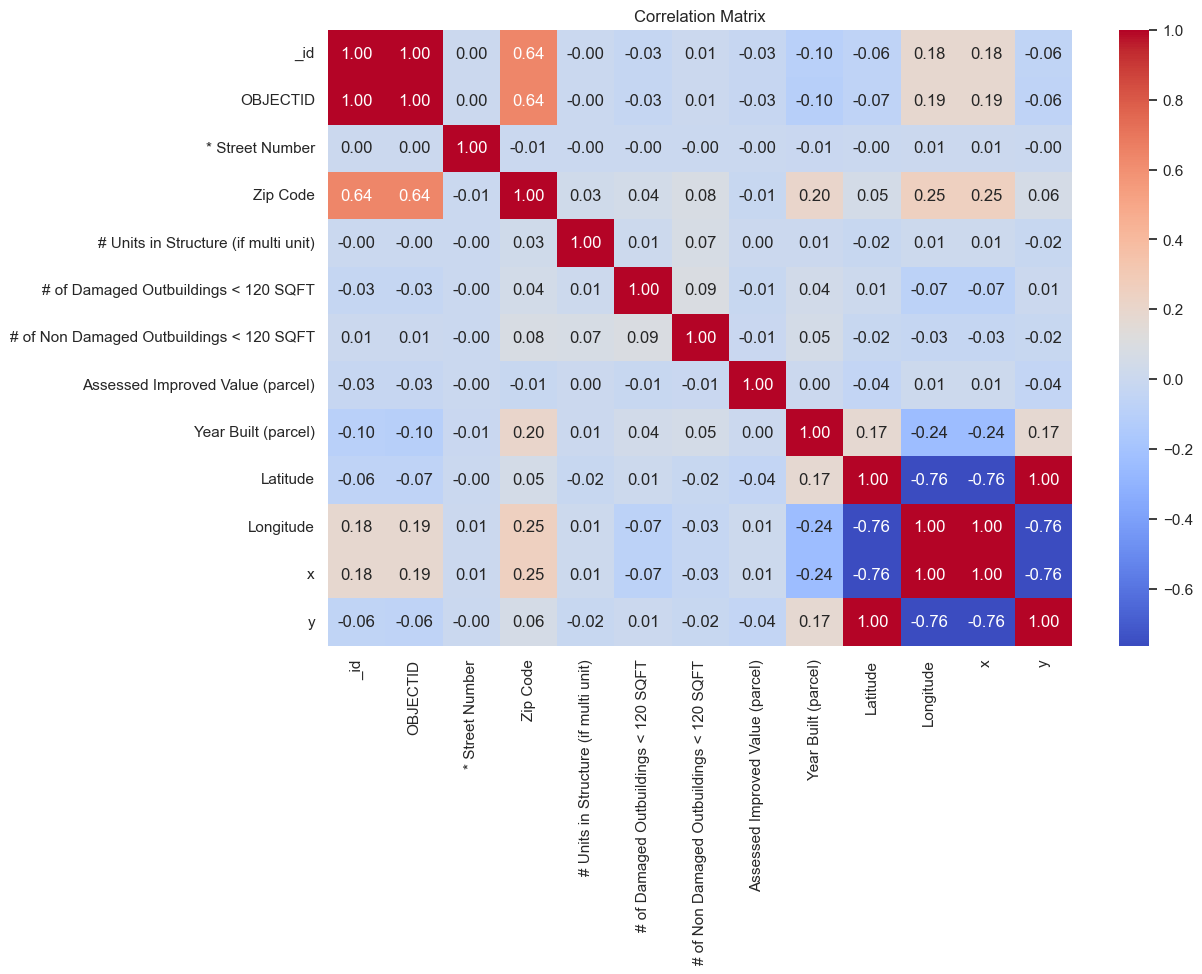

In [16]:
# Select numeric columns only
numeric_cali = cali.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr = numeric_cali.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# Predicting Damage

In [32]:
# Convert to numeric, coercing errors to NaN
cali['* Street Number'] = pd.to_numeric(cali['* Street Number'], errors='coerce')

# Convert to Int64 (optional, to use nullable integer type)
cali['* Street Number'] = cali['* Street Number'].astype('Int64')

In [36]:
cali

,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,...,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,1,No Damage,8376,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,2,Affected (1-9%),8402,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,3,No Damage,8430,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06
3,4,4,No Damage,3838,Putah Creek,Road,NaN,Winters,CA,NaN,...,Quail,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06
4,5,5,No Damage,3830,Putah Creek,Road,NaN,Winters,CA,NaN,...,Quail,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100225,100226,101217,No Damage,24198,Case,Court,blding A,Malibu,CA,90265.0,...,NaN,4458018039.0,2249521.0,0.0,"24198 CASE CT, MALIBU, CA 90265",1b537de2-8b97-43ee-9d5c-c5a426f604f1,34.033408,-118.700625,-1.321369e+07,4.033289e+06
100226,100227,101218,No Damage,24198,Case,Court,blding B,Malibu,CA,90265.0,...,NaN,4458018039.0,2249521.0,0.0,"24198 CASE CT, MALIBU, CA 90265",56e3cc8b-4bf0-4beb-bd26-b54422cc31ee,34.033278,-118.700902,-1.321372e+07,4.033271e+06
100227,100228,101219,No Damage,24198,Case,Court,blding C,Malibu,CA,90265.0,...,NaN,4458018039.0,2249521.0,0.0,"24198 CASE CT, MALIBU, CA 90265",f85e9f02-a67f-4a7d-9fa1-0b8bf419d51a,34.033618,-118.701102,-1.321375e+07,4.033317e+06
100228,100229,101220,No Damage,24008,Malibu,Road,NaN,Malibu,CA,90265.0,...,NaN,4458009014.0,5983875.0,2016.0,"24008 MALIBU RD, MALIBU, CA 90265",51b2df1f-852e-4f36-b250-b383c93e4042,34.032085,-118.698270,-1.321343e+07,4.033111e+06


In [37]:
Y_var = cali[['_id','* Damage']]

In [43]:
Y_var['* Damage'].unique()

array(['No Damage', 'Affected (1-9%)', 'Minor (10-25%)',
       'Destroyed (>50%)', 'Major (26-50%)', 'Inaccessible'], dtype=object)

## One hot encoding

In [52]:
# Encode the target variable
ordinal_mapping = {
    'No Damage': 0,
    'Affected (1-9%)': 1,
    'Minor (10-25%)': 2,
    'Major (26-50%)': 3,
    'Destroyed (>50%)': 4,
    'Inaccessible': 5
}
cali['target'] = cali['* Damage'].map(ordinal_mapping)


In [55]:
cali.sample(10) 
##Could it be possible that we have a biased target variable?


,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,...,APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y,target
86655,86656,86656,Destroyed (>50%),5790,N Arm,Road,C,Taylorsville,CA,95983.0,...,004230017,92793.0,NaN,5790 N ARM RD TAYLORSVILLE CA 95983,ad5e50b0-d17d-46c2-9965-8cd4d1ea0e47,40.143430,-120.793036,-1.344662e+07,4.886807e+06,4
68422,68423,68423,Destroyed (>50%),0,Mt. Veeder,Road,B,Unincorporated,CA,0.0,...,034360002000,96847.0,1946.0,3535 MOUNT VEEDER RD,47bad30c-1c46-4221-93f5-c39cdcc07f33,38.386624,-122.448164,-1.363087e+07,4.634188e+06,4
57597,57598,57598,No Damage,0,,NaN,NaN,Los Angeles,CA,0.0,...,4377020007,1385053.0,1962.0,1239 LINDA FLORA DR LOS ANGELES CA 90049,e03ec45d-7ab5-449e-996b-030f757298d0,34.093135,-118.466117,-1.318759e+07,4.041315e+06,0
19744,19745,19745,No Damage,5300,Monticello,Road,B,NaN,CA,NaN,...,032390004000,182442.0,1984.0,5300 MONTICELLO RD NAPA CA 94558,facbde02-7c01-41c1-9ee6-45ee9daaa616,38.432748,-122.202349,-1.360350e+07,4.640740e+06,0
86671,86672,86672,No Damage,3405,Diamond Mountain,Road,C,Greenville,CA,95947.0,...,004220021,139026.0,NaN,3405 DIAMOND MOUNTAIN RD GREENVILLE CA 95947,803c8566-71fa-4152-9ace-6009d087cc6d,40.141251,-120.820786,-1.344971e+07,4.886490e+06,0
68090,68091,68091,Destroyed (>50%),830,Hillside,Drive,0,Weed,CA,0.0,...,,60248.0,NaN,830 HILLSIDE DR,abf11191-aa4e-49f3-9508-c9080095ca9b,41.427689,-122.375921,-1.362283e+07,5.075632e+06,4
59914,59915,59915,Destroyed (>50%),3534,Santiago,Drive,NaN,Santa Rosa,CA,0.0,...,034-371-005,284000.0,NaN,3534 SANTIAGO DR SANTA ROSA CA 95403,23a75bc7-5790-4924-93c6-88fcf32351e3,38.476577,-122.751864,-1.366467e+07,4.646971e+06,4
84080,84081,84081,Destroyed (>50%),114,Crescent,Street,NaN,Greenville,CA,95947.0,...,110063018,206545.0,NaN,114 CRESCENT ST GREENVILLE CA 95947,f8539ee2-5e38-438d-bbf7-0052c7092607,40.139575,-120.950046,-1.346410e+07,4.886246e+06,4
69605,69606,69606,Destroyed (>50%),4966,Lakepointe,Circle,NaN,Santa Rosa,CA,0.0,...,173-740-006,360752.0,NaN,4966 LAKEPOINTE CIR SANTA ROSA CA 95403,f4416c83-ef56-4b2f-8789-feb24fe8ef35,38.490040,-122.718631,-1.366098e+07,4.648885e+06,4
47626,47627,47627,Destroyed (>50%),5811,Nielsen,Drive,B,Paradise Southeast A,CA,NaN,...,053-230-135-000,192474.0,1976.0,5811 NIELSEN DR PARADISE CA 95969,a92a341b-65be-4469-b4f5-9913cebb631b,39.757891,-121.586926,-1.353499e+07,4.830822e+06,4


In [63]:
# Encode categorical features (if any)
# categorical_cols = cali.select_dtypes(include=['object']).columns.tolist()
# for col in categorical_cols:
#     cali[col] = cali[col].astype('category')


cali.describe(include='all')






,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,* CAL FIRE Unit,County,Community,Battalion,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,Hazard Type,If Affected 1-9% - Where did fire start?,If Affected 1-9% - What started fire?,Structure Defense Actions Taken,* Structure Type,Structure Category,# Units in Structure (if multi unit),# of Damaged Outbuildings < 120 SQFT,# of Non Damaged Outbuildings < 120 SQFT,* Roof Construction,* Eaves,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure,Distance - Propane Tank to Structure,Distance - Residence to Utility/Misc Structure &gt; 120 SQFT,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y,target
count,100230.000000,100230.000000,100230,95810.0,94744,87033,44148,68616,100223,47429.000000,100230,100200,52892,6398,100230,100230,100230,100230,10740,9016,24470,100230,100230,31184.000000,31085.000000,31073.00000,99602,99118,99032,99321,99254,100230,100230,100230,78635,23057,14356,21171,99613,9.419500e+04,69812.000000,95591,100230,100230.000000,100230.000000,1.002300e+05,1.002300e+05,100230.000000
unique,NaN,NaN,6,<NA>,9820,27,2263,442,1,NaN,27,50,1001,30,270,294,294,3,18,9,10,19,7,NaN,NaN,NaN,11,6,10,11,7,6,6,5,4,6,6,23,56857,NaN,NaN,53338,100230,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Destroyed (>50%),<NA>,Pentz,Road,A,Unincorporated,CA,NaN,BTU,Butte,Paradise,5,Camp,CABTU 016737,11/8/2018 12:00:00 AM,Fire,Unknown,Unknown,Unknown,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Unknown,Unknown,Wood,Multi Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,Unknown,<30',CZU Lightning Complex,018060086000,NaN,NaN,,e1919a06-b4c6-476d-99e5-f0b45b070de8,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,53879,<NA>,750,42228,13343,16201,100223,NaN,28774,28715,7457,1727,23624,23624,25637,100228,8551,5666,17894,33692,65520,NaN,NaN,NaN,37496,39588,31912,24266,33801,30317,43227,40854,46200,6646,7049,4820,258,NaN,NaN,1850,1,NaN,NaN,NaN,NaN,NaN
mean,50115.500000,50227.779717,NaN,38867.218923,NaN,NaN,NaN,NaN,NaN,46309.699973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.433299,0.087566,0.12152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.337022e+05,1672.283862,NaN,NaN,38.322953,-121.179297,-1.348962e+07,4.629002e+06,2.243460
std,28934.053078,29107.678335,NaN,5271694.85755,NaN,NaN,NaN,NaN,NaN,47467.653484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.608767,0.462729,0.52558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.603013e+06,708.451814,NaN,NaN,2.019086,1.538342,1.712474e+05,2.825063e+05,1.949898
min,1.000000,1.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,32.592548,-123.774580,-1.377852e+07,3.841346e+06,0.000000
25%,25058.250000,25058.250000,NaN,723.25,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.937000e+04,1944.000000,NaN,NaN,37.350926,-122.316162,-1.361617e+07,4.488135e+06,0.000000
50%,50115.500000,50115.500000,NaN,4308.5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.455510e+05,1972.000000,NaN,NaN,38.692955,-121.600277,-1.353648e+07,4.677785e+06,4.000000
75%,75172.750000,75172.750000,NaN,10003.0,NaN,NaN,NaN,NaN,NaN,95667.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.109355e+05,1987.000000,NaN,NaN,39.763874,-120.509278,-1.341503e+07,4.831688e+

## Understanding features

In [66]:
for column in cali.columns:
    print(f"Unique values in {column}:")
    print(cali[column].unique()[:10])  # Display the first 10 unique values
    print("\n")


Unique values in _id:
[ 1  2  3  4  5  6  7  8  9 10]


Unique values in OBJECTID:
[ 1  2  3  4  5  6  7  8  9 10]


Unique values in * Damage:
['No Damage' 'Affected (1-9%)' 'Minor (10-25%)' 'Destroyed (>50%)'
 'Major (26-50%)' 'Inaccessible']


Unique values in * Street Number:
<IntegerArray>
[8376, 8402, 8430, 3838, 3830, 3834, 3806, 3749, 3786, 3778]
Length: 10, dtype: Int64


Unique values in * Street Name:
['Quail Canyon' 'Quail Canyon ' 'Putah Creek' 'Putah creek '
 'Pleasants Valley' 'Pleasants valley ' 'Olive School ' 'Olive School'
 'Coyote Hill' 'Eucalyptus ']


Unique values in * Street Type (e.g. road, drive, lane, etc.):
['Road' 'Lane' 'Other' 'Trail' 'Drive' 'Street' nan 'Way' 'Avenue' 'Court']


Unique values in Street Suffix (e.g. apt. 23, blding C):
[nan 'B' 'Building B' 'Building A' 'Building C' 'D' 'E' 'F' 'G' 'H']


Unique values in * City:
['Winters' 'Winters ' 'RAncho Cordova' 'Oroville' 'Pismo Beach' 'Dorris'
 'Macdoel' 'Gilroy' 'Bangor ' 'Bangor']


Unique valu

In [67]:
cali.head(5)

,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,* CAL FIRE Unit,County,Community,Battalion,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,Hazard Type,If Affected 1-9% - Where did fire start?,If Affected 1-9% - What started fire?,Structure Defense Actions Taken,* Structure Type,Structure Category,# Units in Structure (if multi unit),# of Damaged Outbuildings < 120 SQFT,# of Non Damaged Outbuildings < 120 SQFT,* Roof Construction,* Eaves,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure,Distance - Propane Tank to Structure,Distance - Residence to Utility/Misc Structure &gt; 120 SQFT,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y,target
0,1,1,No Damage,8376,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,8.0,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Multi Story,Single Residence,1.0,NaN,NaN,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Single Pane,Wood,Wood,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06,0
1,2,2,Affected (1-9%),8402,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,Deck on Grade,Unknown,Hand Crew Fuel Break,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,Combustible,NaN,NaN,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06,1
2,3,3,No Damage,8430,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Enclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06,0
3,4,4,No Damage,3838,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Unenclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,Combustible,No Fence,NaN,NaN,Quail,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06,0
4,5,5,No Damage,3830,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Tile,Enclosed,"Mesh Screen > 1/8""""",Wood,Multi Pane,Wood,Wood,Combustible,No Fence,NaN,NaN,Quail,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06,0


In [68]:
cali.columns

Index(['_id', 'OBJECTID', '* Damage', '* Street Number', '* Street Name',
       '* Street Type (e.g. road, drive, lane, etc.)',
       'Street Suffix (e.g. apt. 23, blding C)', '* City', 'State', 'Zip Code',
       '* CAL FIRE Unit', 'County', 'Community', 'Battalion',
       '* Incident Name', 'Incident Number (e.g. CAAEU 123456)',
       'Incident Start Date', 'Hazard Type',
       'If Affected 1-9% - Where did fire start?',
       'If Affected 1-9% - What started fire?',
       'Structure Defense Actions Taken', '* Structure Type',
       'Structure Category', '# Units in Structure (if multi unit)',
       '# of Damaged Outbuildings < 120 SQFT',
       '# of Non Damaged Outbuildings < 120 SQFT', '* Roof Construction',
       '* Eaves', '* Vent Screen', '* Exterior Siding', '* Window Pane',
       '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Distance - Propane Tank to Structure',
    

/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/3802746103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cali, y='* Structure Type', ax=axes[0, 0], palette='plasma')
/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/3802746103.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cali, y='* Roof Construction', ax=axes[0, 1], palette='cividis')
/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/3802746103.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cali, y='* CAL FI

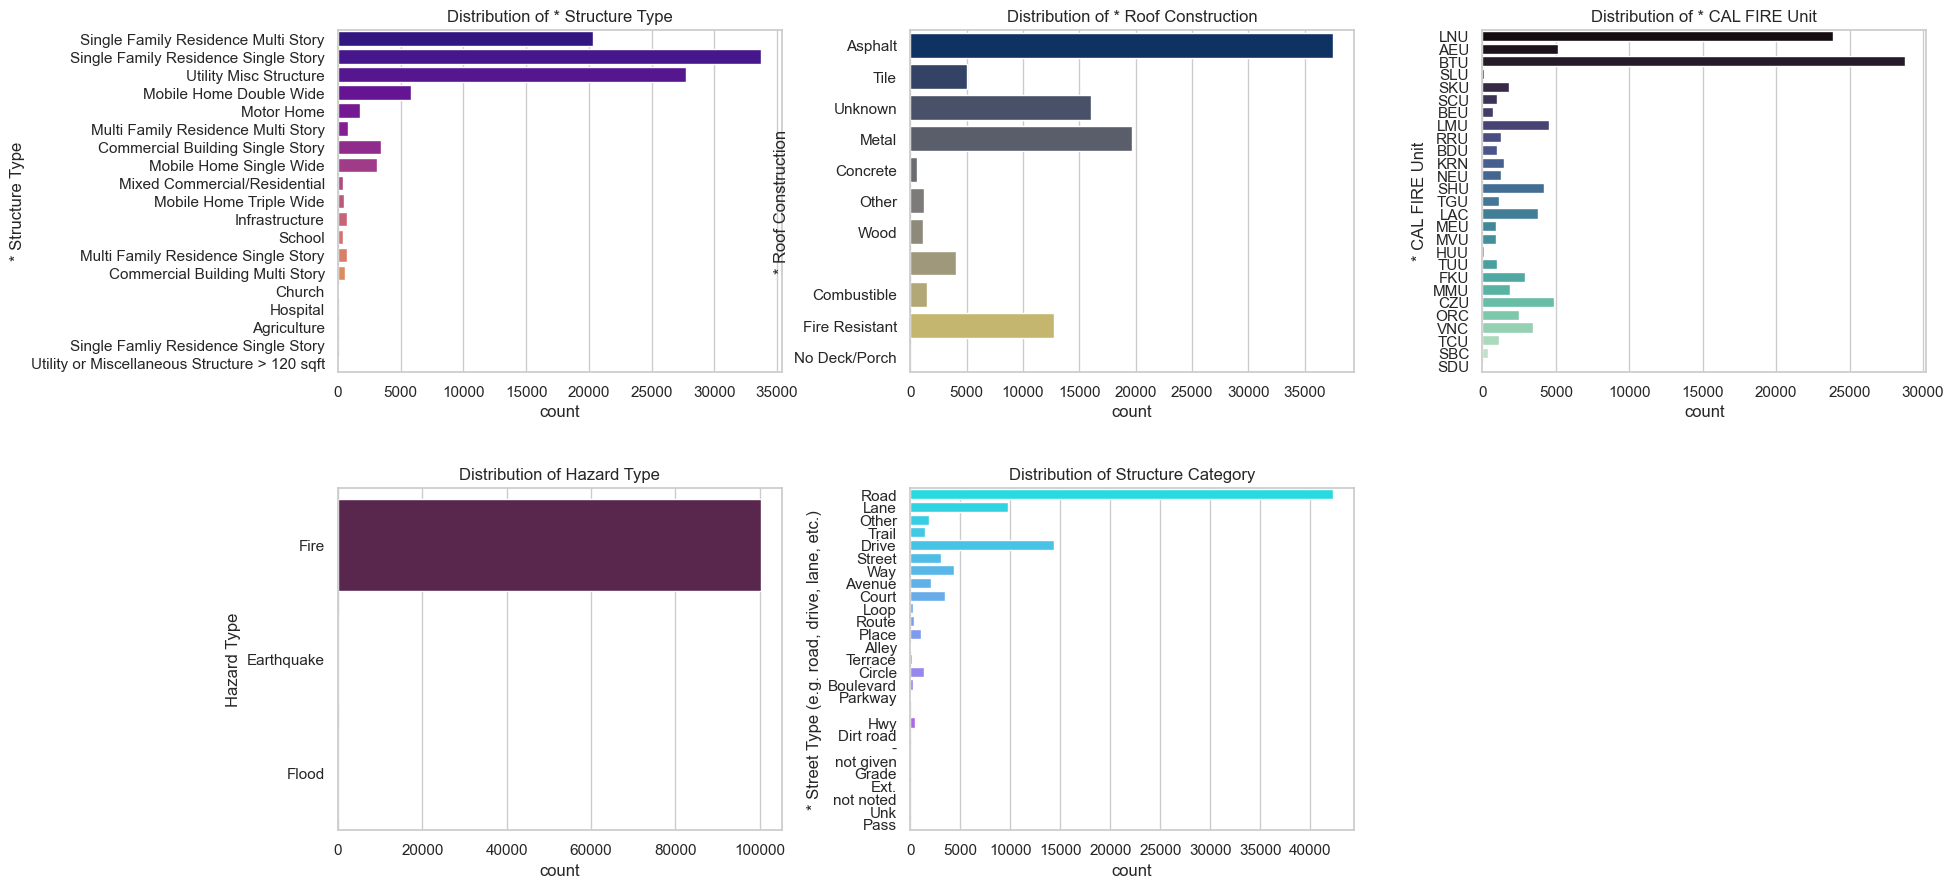

In [76]:
# Selecting an additional variable for visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.tight_layout(pad=5.0)

# Graph 1: * Structure Type
sns.countplot(data=cali, y='* Structure Type', ax=axes[0, 0], palette='plasma')
axes[0, 0].set_title('Distribution of * Structure Type')

# Graph 2: * Roof Construction
sns.countplot(data=cali, y='* Roof Construction', ax=axes[0, 1], palette='cividis')
axes[0, 1].set_title('Distribution of * Roof Construction')

# Graph 3: * CAL FIRE Unit
sns.countplot(data=cali, y='* CAL FIRE Unit', ax=axes[0, 2], palette='mako')
axes[0, 2].set_title('Distribution of * CAL FIRE Unit')

# Graph 4: Hazard Type
sns.countplot(data=cali, y='Hazard Type', ax=axes[1, 0], palette='rocket')
axes[1, 0].set_title('Distribution of Hazard Type')


sns.countplot(data=cali, y='* Street Type (e.g. road, drive, lane, etc.)', ax=axes[1, 1], palette='cool')
axes[1, 1].set_title('Distribution of Structure Category')

# Remove extra empty plot
fig.delaxes(axes[1, 2])

plt.show()


## LGBoost

In [ ]:

# Split data into features and target
X = cali.drop(columns=['target'])
y = cali['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_cols, free_raw_data=False)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 6,  # Number of classes in your target
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'verbosity': -1,
        'random_state': 42
    }

    # Train the model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict on the test set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = lgb.train(
    {**best_params, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss', 'verbosity': -1},
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# Evaluate the final model
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=list(ordinal_mapping.keys())))import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import optuna

# Load your dataset
# cali = pd.read_csv('your_data.csv')

# Encode the target variable
ordinal_mapping = {
    'No Damage': 0,
    'Affected (1-9%)': 1,
    'Minor (10-25%)': 2,
    'Major (26-50%)': 3,
    'Destroyed (>50%)': 4,
    'Inaccessible': 5
}
cali['target'] = cali['damage_category'].map(ordinal_mapping)

# Drop the original categorical column
cali.drop(columns=['damage_category'], inplace=True)

# Encode categorical features (if any)
categorical_cols = cali.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    cali[col] = cali[col].astype('category')

# Split data into features and target
X = cali.drop(columns=['target'])
y = cali['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_cols, free_raw_data=False)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 6,  # Number of classes in your target
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'verbosity': -1,
        'random_state': 42
    }

    # Train the model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict on the test set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = lgb.train(
    {**best_params, 'objective': 'multiclass', 'num_class': 6, 'metric': 'multi_logloss', 'verbosity': -1},
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# Evaluate the final model
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=list(ordinal_mapping.keys())))

# Dash


In [6]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the dashboard
app.layout = html.Div([
    html.H1("California Fire Incident Data Dashboard"),
    
    dcc.Dropdown(
        id='damage-dropdown',
        options=[{'label': i, 'value': i} for i in cali['* Damage'].unique()],
        value=cali['* Damage'].unique()[0],
        multi=True
    ),
    
    dcc.Graph(id='damage-graph')
])

# Callback to update the graph
@app.callback(
    Output('damage-graph', 'figure'),
    [Input('damage-dropdown', 'value')]
)
def update_graph(selected_damage):
    filtered_cali = cali[cali['* Damage'].isin(selected_damage)]
    fig = px.scatter(filtered_cali, x='Longitude', y='Latitude', color='* Damage', title='Fire Incidents by Damage Type')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_8856/249547489.py in update_graph(selected_damage='No Damage')
     27 )
     28 def update_graph(selected_damage):
---> 29     filtered_cali = cali[cali['* Damage'].isin(selected_damage)]
        filtered_cali = undefined
        global cali =            _id  OBJECTID         * Damage  * Street Number  * Street Name  \
0            1         1        No Damage           8376.0   Quail Canyon   
1            2         2  Affected (1-9%)           8402.0   Quail Canyon   
2            3         3        No Damage           8430.0  Quail Canyon    
3            4         4        No Damage           3838.0    Putah Creek   
4            5         5        No Damage           3830.0    Putah Creek   
...        ...       ...              ...              ...            ...   
10022

In [9]:
import geopandas as gpd

# Load the geojson file
file_path = '/Users/isaacfernandez/Downloads/Cali Data/POSTFIRE_MASTER_DATA_SHARE_140463065990229786.geojson'
data = gpd.read_file(file_path)

# Display basic information about the GeoDataFrame
data_info = data.info()
data_head = data.head()

data_info, data_head




ModuleNotFoundError: No module named 'geopandas'